# Bioinformatics (MTAT.03.239)
# Assignment 4

Student: ChengHan Chung

----

## Task 1: Understanding the VCF file format (2 points)

1. Start an interactive slurm job with srun `--pty bash`. This way you can run the following commands interactively on one of the HPC comupte nodes without submitting them as slurm jobs with sbatch.
2. Extract the genotypes of the rs4988235 genetic variant from the the VCF file. One way to do this is to use the bcftools command line utility: `module load bcftools-1.9` `bcftools view -r <chr>:<position> <path_to_vcf_file>`

    **(A) :** The result of extracting the genotypes of the **rs4988235** genetic variant whcih located on chromosome 2 on position 135851076, please check the file `output.txt`.

3. Convert the genotypes from the numerical representation in the VCF file to reference and alternative alleles (AA, AG, or GG).

    **(A) :** The result of converting the label of genotypes, please check following `code`.

4. Count the frequencies of the AA, AG and GG genotypes in each of the 5 populations and make a table or a barplot. You can find which sample belongs to which population from the ´GEUVADIS_populations.tsv´ text file located in the same folder with the VCF file in the HPC. You can ignore the one individual (NA19171) with missing population information. Which population has the largest fraction of people who are likely to be able to drink milk? Which one has the lowest?

    **(A) :** The result of plot:

    ![](imgs/ex1_01.png)

    Accoding to the plot shown as above, the people from CEPH has the largest fraction (92.13%), who are likely to be able to drink milk. and the people from Yoruba has lowest rate (0%).

    ![](imgs/ex1_02.png)

         AA  GG  AG
Tuscan    2  76  13
CEPH     47   7  35
Finnish  30  13  49
British  45   8  33
Yoruba    0  86   0
NaN       0   1   0


<AxesSubplot:>

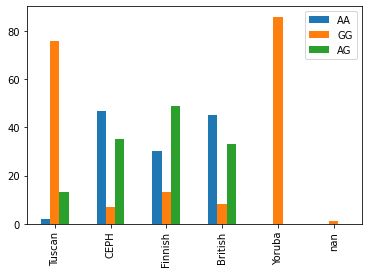

In [14]:
import pandas as pd

_GEUVADIS_POPULATIONS_FILE = r'GEUVADIS_populations.tsv'
_GENOTYPE_FILE = r'output.txt'

# G:0, A:1
genotpte_dic = {'1|0': 'AG', '1|1': 'AA', '0|0': 'GG', '0|1': 'AG'}
genotptes = []
genotptes_cnt_dic = {}
geno_map_dic = {}
geno_lst = []
population_lst = []

populations_df = pd.read_csv(_GEUVADIS_POPULATIONS_FILE, sep='\t')

with open(_GENOTYPE_FILE) as f:
    data = f.readlines()


geno_lst = data[-1][:-1]
geno_lst = geno_lst.split('\t')

population_lst = data[-2][:-1]
population_lst = population_lst.split('\t')

for i in range(len(geno_lst)):
    geno_map_dic[population_lst[i]] = geno_lst[i]

for key, value in geno_map_dic.items():
    if value not in genotpte_dic.keys():
        continue
    else:
        try:
            population_name = populations_df.loc[populations_df['genotype_id']
                                                 == key]['population_name'].values[0]
            genotptes_cnt_dic[population_name][genotpte_dic[value]] += 1
        except KeyError:
            genotptes_cnt_dic[population_name] = {'AA': 0, 'GG': 0, 'AG': 0}
            genotptes_cnt_dic[population_name][genotpte_dic[value]] = 1

# create data
df = pd.DataFrame(genotptes_cnt_dic.values(),
                  columns=['AA', 'GG', 'AG'],
                  index=genotptes_cnt_dic.keys())
# view data
print(df)

# plot grouped bar chart
df.plot(kind='bar',
        stacked=False)

## Task 2: Characterising population structure using PCA (1.5 points)

1. Perform PCA on the GEUVADIS genotype dataset using the QTLtools command described above. This will create a text file containing the principal component loadings for each sample in the VCF file.

    **(A) :** The execution shown as following below:
    ![](imgs/ex2_01.png)
    ![](imgs/ex2_02.png)


2. Import the principal components file into R (or Python) and make scatter plot of the first two principal components. Colour the samples according to their population_code in the GEUVADIS_populations.tsv. Can you see a clear separation between European and African populations?
    
    **(A) :** The plot shown as following below, there is a clear separation between European(red dot) and African(green dot) populations
    
    ![](imgs/ex2_03.png)

3. One of the samples (NA19171) in the GEUVADIS_populations.tsv file was missing the population information. Based on the PCA plot, can you predict the population from which the sample comes from?

    **(A) :** Yes, according to the plot, the missing data(blue dot) is close to African(green dot), therefore, the missing data comes from `African`.

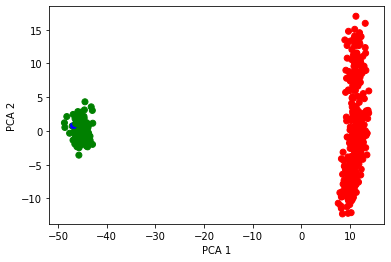

In [115]:
import numpy as np
from matplotlib import pyplot as plt

_GEUVADIS_PCA_FILE = r'GEUVADIS_pca.pca'

pca_df = pd.read_csv(_GEUVADIS_PCA_FILE, sep=" ")

pc1 = pca_df.loc[0][1:]
pc2 = pca_df.loc[1][1:]

pc1_lst = [[key, value] for key, value in pc1.items()]
pc2_lst = [[key, value] for key, value in pc2.items()]

for i in range(len(pc1_lst)):
    pc1_lst[i][0] = populations_df.loc[populations_df['genotype_id']
                                       == pc1_lst[i][0]]['superpopulation_code'].values[0]
    pc2_lst[i][0] = populations_df.loc[populations_df['genotype_id']
                                       == pc2_lst[i][0]]['superpopulation_code'].values[0]
x = [value[1] for value in pc1_lst]
y = [value[1] for value in pc2_lst]
labels = [value[0] for value in pc1_lst]
pca_df = pd.DataFrame(data={'superpopulation_code': labels,
                      'x': x,
                            'y': y})

label_color = {'EUR': 'red', 'AFR': 'green', np.nan: 'blue'}


plt.scatter(pca_df['x'], pca_df['y'],
            c=pca_df['superpopulation_code'].map(label_color))
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

## Task 3: Matching RNA-seq samples to individuals in the VCF file (1.5 points)

1. Describe in your own words in 4-5 sentences how the QTLtools mbv method works and how it can be used to detect matches between genotyped individuals and sequencing reads from RNA-seq experiment. I strongly recommend you to read the QTLtools mbv publication and Supplementary Information on the journal website.
2. Once you have run QTLtools mbv, import the results into R (or Python) and make a scatter plot where on one axis you have the fraction of concordant heterozygous sites (n_het_consistent/n_het_covered from output file) and on the other axis you have the fraction of concordant homozygous sites (n_hom_consistent/n_hom_covered). Note that you need to calculate these ratios yourself as described above. Based on this plot, are you able to determine which individual is likely to correspond the ERR188146 RNA-seq sample?